In [2]:
import cv2
from PIL import Image
import glob, os
import json
from globox import AnnotationSet
from pathlib import Path
import xml.etree.ElementTree as ET
from pylabel import importer
import pandas as pd
from IPython.display import Image, display

In [2]:
def norm2abs(bbx_coords, image_shape):
    x, y, w, h, = bbx_coords

    # get x and y
    x_reg = int(x * image_shape[1])
    y_reg = int(y * image_shape[0])
    w_reg = int(w * image_shape[1])
    h_reg = int(h * image_shape[0])

    bbx_coords_reg = [x_reg, y_reg, w_reg, h_reg]
    return bbx_coords_reg

In [5]:
# Check image dimensions, bounding box coordinates and labels
# We will compare the normalised and absolute coordinates, we assume the two json files are keyed identically
root = 'C:/Users/drago/Documents/gitrepos/Cross-Recessed-Screw_Deep-Learning-Datasets/'
directory = root + 'Test_Set_B_Images/'
check_shape = False

#abs_labels_dir = root + 'Completed_Labels.json'
abs_labels_dir = root + 'Test_Set_B_Images/coco_small.json'


In [ ]:
def visualise_data(abs_labels__in_json):
    # Open the json file containing the absolute labels
    with open(abs_labels_dir) as abs_labels_json:
        abs_labels_dict = json.load(abs_labels_json)

    # Iterate through each image in abs_labels, extracting filename and id
    for file in [{'name': image['file_name'].split('/')[-1], 'id': image['id']} for image in abs_labels_dict['images'][:]]:
        if file['name'].endswith('.png') or file['name'].endswith('.jpg'):
            # Read in the image
            dataset_img = cv2.imread(directory + file['name'])
            
            # Extract the bounding boxes for each screw in the image
            label_ids = []
            for index, abs_label in enumerate(abs_labels_dict['annotations'][:]):
                # Find the annotations that match the image
                # I want to know which images have annotations of area zero
                if abs_label['image_id'] == file['id']:

                    # Read in absolute bounding box coordinates
                    coordinates = abs_label['bbox']

                    #Display image with bounding box
                    start_point = (int(coordinates[0]), int(coordinates[1]))
                    end_point = (int(coordinates[0] + coordinates[2]), int(coordinates[1] + coordinates[3]))
                    
                    print(start_point, end_point)
                    print('\n')

                    if abs_label['category_id'] == 2:
                        colour = (0, 0, 255)
                    if abs_label['category_id'] == 4:
                        colour = (255, 0, 0)
                    # draw the rectangle
                    cv2.rectangle(dataset_img, start_point, end_point, color=colour, thickness= 1, lineType=cv2.LINE_8)

                    print("Image details: {}".format(file))
                    print("Label details: {}".format(abs_label))

            print("Zero area bounding box found in image {}".format(file['name']))
            # display the output
            print("Dimensions {}: {}".format(file['name'], dataset_img.shape))
            cv2.imshow('imageRectangle', dataset_img)
            if cv2.waitKey(0) == 27: break
            else: continue
        else:
            continue

    cv2.destroyAllWindows()

visualise_data(abs_labels_dir)

In [4]:
def xml_to_json(xml_folder, xml_images_folder, xml_annots_folder, coco_file_name, coco_keys):
    # Get the xml folder path
    xml_images = os.path.join(xml_folder, xml_images_folder)
    xml_annots = os.path.join(xml_folder, xml_annots_folder)
    coco_path = os.path.join(xml_annots, coco_file_name)

    # Initialize the coco dictionary
    coco_dict = {}
    for key in coco_keys:
        coco_dict[key] = []

    print(xml_annots)
    # Loop through the xml files in the folder
    for xml_file in os.listdir(xml_annots):
        if os.path.join(xml_annots, xml_file).endswith(".xml") == False:
            continue

        # Parse the xml file
        tree = ET.parse(os.path.join(xml_annots, xml_file))
        root = tree.getroot()

        # Get the image id, file name, width and height from the xml file
        image_id = int(root.find("filename").text.split(".")[0])
        file_name = xml_images + root.find("filename").text
        width = int(root.find("size/width").text)
        height = int(root.find("size/height").text)
        depth = int(root.find("size/depth").text)

        # Append the image information to the coco dictionary
        coco_dict["images"].append({
            "id": image_id,
            "file_name": file_name,
            "width": width,
            "height": height,
            "depth": depth
        })

        # Loop through the objects in the xml file
        for obj in root.findall("object"):
            # Get the category id, name, bounding box coordinates and segmentation points from the xml file
            category_id = 2 if obj.find("name").text == 'cross_recessed_screw' else 0
            category_name = obj.find("name").text
            xmin = int(obj.find("bndbox/xmin").text)
            ymin = int(obj.find("bndbox/ymin").text)
            xmax = int(obj.find("bndbox/xmax").text)
            ymax = int(obj.find("bndbox/ymax").text)

            # Calculate the area and width and height of the bounding box
            area = (xmax - xmin) * (ymax - ymin)
            bbox_width = xmax - xmin
            bbox_height = ymax - ymin

            # Append the annotation information to the coco dictionary
            coco_dict["annotations"].append({
                "id": len(coco_dict["annotations"]) + 1,
                "image_id": image_id,
                "category_id": category_id,
                "area": area,
                "bbox": [xmin, ymin, bbox_width, bbox_height]
            })

            # Append the category information to the coco dictionary if not already present
            if category_id not in [cat["id"] for cat in coco_dict["categories"]]:
                coco_dict["categories"].append({
                    "id": category_id,
                    "name": category_name,
                    "supercategory": category_name
                })

    # Write the coco dictionary to the output file as json format
    with open(coco_path, "w") as f:
        json.dump(coco_dict, f, indent=4)

    print(f"Successfully converted {len(os.listdir(xml_annots))} xml files to {coco_path}")

xml_to_json(xml_folder='C:/Users/drago/Documents/gitrepos/Cross-Recessed-Screw_Deep-Learning-Datasets/',
            xml_images_folder='Test_Set_B_Images/',
            xml_annots_folder='Test_Set_B_Annotations/',
            coco_file_name='coco.json', coco_keys=["file_name", "licenses", "images", "annotations", "categories"])

C:/Users/drago/Documents/gitrepos/Cross-Recessed-Screw_Deep-Learning-Datasets/Test_Set_B_Annotations/
Successfully converted 92 xml files to C:/Users/drago/Documents/gitrepos/Cross-Recessed-Screw_Deep-Learning-Datasets/Test_Set_B_Annotations/coco.json


In [8]:
def shrink_images_and_labels(source_images, source_annotations, target_images, target_annotations):
    # First check if images exist in the target directory
    if glob.glob(target_images + "*.jpg") == []:
        # Need to shrink and copy images across
        for infile in glob.glob(source_images + "*.jpg"):
            file, ext = os.path.splitext(infile)
            file_name = os.path.basename(file)
            with Image.open(infile) as im:
                # When the image is in portrait mode, scale by flipped dimensions
                if im.size[0] > im.size[1]:
                    im.thumbnail((640, 480))
                else:
                    im.thumbnail((480, 640))
                
                im.save(target_images + file_name + '.jpg', "JPEG")

    # Now check if the labels exist in the target directory
    if glob.glob(target_annotations + "*.json") == []:
        # rewrite the follwing if statement using the function variables
        # Open the json file containing the absolute labels
        with open(source_annotations) as abs_labels_json:
            abs_labels_dict = json.load(abs_labels_json)

        for image in abs_labels_dict['images']:
            old_width = image['width']
            old_height = image['height']

            if image['width'] > old_height:
                image['width'] = 640
                image['height'] = 480
            else:
                image['width'] = 480
                image['height'] = 640
            
            # Change the image filename
            image['file_name'] = target_images + image['file_name'].split('/')[-1]
            
            # Update the annotations
            for annotation in abs_labels_dict['annotations']:
                if annotation['image_id'] == image['id']:
                    annotation['bbox'][0] = int(annotation['bbox'][0] * image['width'] / old_width)
                    annotation['bbox'][1] = int(annotation['bbox'][1] * image['height'] / old_height)
                    annotation['bbox'][2] = int(annotation['bbox'][2] * image['width'] / old_width)
                    annotation['bbox'][3] = int(annotation['bbox'][3] * image['height'] / old_height)
                    annotation['area'] = annotation['bbox'][2] * annotation['bbox'][3]

        with open(target_annotations, 'w') as labels_json:
            json.dump(abs_labels_dict, labels_json, indent=4)

root = 'C:/Users/drago/Documents/gitrepos/Cross-Recessed-Screw_Deep-Learning-Datasets/'
source_images = root + 'Test_Set_B_Images/'
source_annotations = root + 'Test_Set_B_Annotations/coco.json'
target_images = root + 'Small_Test_B_Images/'
target_annotations = root + 'Small_Test_B_Annotations/coco_small.json'

shrink_images_and_labels(source_images, source_annotations, target_images, target_annotations)

Total images: 687
Removed Images: 0


In [9]:
def coco_to_yolo(path_to_annotations, path_to_images, path_to_yolo_annotations):
    dataset = importer.ImportCoco(path_to_annotations, path_to_images=path_to_images, name="cross_dataset_1")

    dataset.path_to_annotations = path_to_yolo_annotations

    dataset.export.ExportToYoloV5(output_path=dataset.path_to_annotations, cat_id_index=0)
    return dataset

coco_annotations = "Small_Test_B_Annotations/coco_small.json"
yolo_annotations = "Small_Test_B_Annotations/yolo_small/"
images = "Small_Test_B_Images/"

path_to_dataset = "C:/Users/drago/Documents/gitrepos/Cross-Recessed-Screw_Deep-Learning-Datasets/"

path_to_coco_annotations = path_to_dataset + coco_annotations
path_to_images = path_to_dataset + images
path_to_yolo_annotations = path_to_dataset + yolo_annotations

dataset = coco_to_yolo(path_to_coco_annotations, path_to_images, path_to_yolo_annotations)

Exporting YOLO files...: 100%|██████████| 90/90 [00:00<00:00, 229.01it/s]


C:\Users\drago\Documents\gitrepos\Cross-Recessed-Screw_Deep-Learning-Datasets\Small_Test_B_Images\000002.jpg


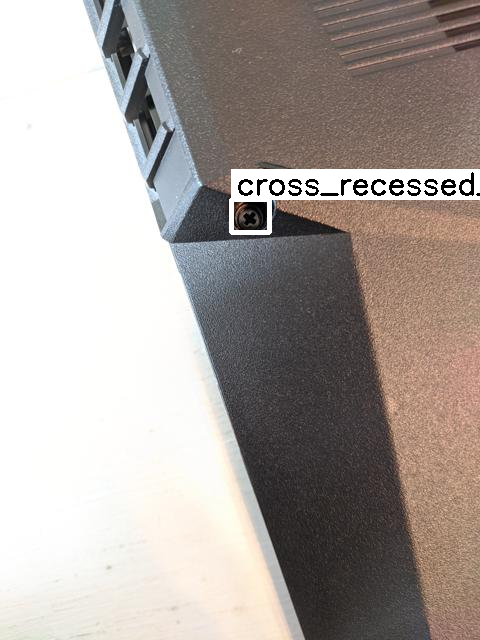

In [10]:

# Check the image dimensions of the dataset
dataset.df[['img_filename', 'ann_bbox_xmin', 'ann_bbox_ymin', 'ann_bbox_xmax', 'ann_bbox_ymax', 'ann_bbox_width', 'ann_bbox_height', 'ann_area']].head()

display(dataset.visualize.ShowBoundingBoxes(2))

In [ ]:
# With yolo dataset
# Iterate through the dataset2 directory, deleting the images that do not have 
project_folder = os.path.abspath('C:/Users/drago/Documents/gitrepos/recycle_robot/')

dataset_2 = os.path.join(project_folder, "Autogathered_Dataset/2 (labeless removed)/Images/")

# Read in the coco.json file to remove the images that do not have labels
with open(project_folder + 'Autogathered_Dataset/2 (labeless removed)/coco.json') as labels_json:
    img_labels_dict = json.load(labels_json)

Formatting dataset 2
Removing images that don't have a corresponding annotation file

In [8]:
# Iterate through the dataset2 directory, deleting the images that do not have annotations files
project_folder = os.path.abspath('C:/Users/drago/Documents/gitrepos/recycle_robot/')
dataset_2 = os.path.join(project_folder, "Autogathered_Dataset/test_dataset/images/")

count = 0
removed_count = 0
for file in os.listdir(dataset_2):
    if file.endswith(".png") or file.endswith(".jpg"):
        # Check if a file by the same name of .txt exists
        filename = os.path.splitext(os.path.join(dataset_2, file))[0]
        txt_file = filename + ".txt"
        #print(txt_file)
        if not os.path.isfile(txt_file):
            print(f"{filename} does not exist as .txt ... deleting: {txt_file}")
            
            os.remove(os.path.join(dataset_2, file))
            removed_count += 1
            continue
        else:
            count += 1

print(f"Total images: {count}")
print(f"Removed Images: {removed_count}")

C:\Users\drago\Documents\gitrepos\recycle_robot\Autogathered_Dataset/test_dataset/images/13 does not exist as .txt ... deleting: C:\Users\drago\Documents\gitrepos\recycle_robot\Autogathered_Dataset/test_dataset/images/13.txt
C:\Users\drago\Documents\gitrepos\recycle_robot\Autogathered_Dataset/test_dataset/images/15 does not exist as .txt ... deleting: C:\Users\drago\Documents\gitrepos\recycle_robot\Autogathered_Dataset/test_dataset/images/15.txt
C:\Users\drago\Documents\gitrepos\recycle_robot\Autogathered_Dataset/test_dataset/images/23 does not exist as .txt ... deleting: C:\Users\drago\Documents\gitrepos\recycle_robot\Autogathered_Dataset/test_dataset/images/23.txt
C:\Users\drago\Documents\gitrepos\recycle_robot\Autogathered_Dataset/test_dataset/images/245 does not exist as .txt ... deleting: C:\Users\drago\Documents\gitrepos\recycle_robot\Autogathered_Dataset/test_dataset/images/245.txt
C:\Users\drago\Documents\gitrepos\recycle_robot\Autogathered_Dataset/test_dataset/images/248 does 

Iterate through directory, removing a annotation files that don't have a corresponding image file

In [5]:
# Iterate through the dataset2 directory, deleting the images that do not have annotations files
project_folder = os.path.abspath('C:/Users/drago/Documents/gitrepos/recycle_robot/')
dataset_2 = os.path.join(project_folder, "Autogathered_Dataset/test_dataset/images/")

count = 0
removed_count = 0
# Iterate through the dataset2 directory for txt files, deleting the images that do not have labels
for file in os.listdir(dataset_2):
    if file.endswith(".txt"):
        # Check if a file by the same name of .png or .jpg exists
        filename = os.path.splitext(os.path.join(dataset_2, file))[0]
        png_file = filename + ".jpg"
        jpg_file = filename + ".png"
        #print(png_file)
        if not os.path.isfile(png_file) and not os.path.isfile(jpg_file):
            print(f"{filename} does not exist as .jpg ... deleting: {png_file}")
            
            os.remove(os.path.join(dataset_2, file))
            removed_count += 1
            continue
        else:
            count += 1

print(f"Total images: {count}")
print(f"Removed Images: {removed_count}")

C:\Users\drago\Documents\gitrepos\recycle_robot\Autogathered_Dataset/test_dataset/images/10 does not exist as .jpg ... deleting: C:\Users\drago\Documents\gitrepos\recycle_robot\Autogathered_Dataset/test_dataset/images/10.jpg
C:\Users\drago\Documents\gitrepos\recycle_robot\Autogathered_Dataset/test_dataset/images/121 does not exist as .jpg ... deleting: C:\Users\drago\Documents\gitrepos\recycle_robot\Autogathered_Dataset/test_dataset/images/121.jpg
C:\Users\drago\Documents\gitrepos\recycle_robot\Autogathered_Dataset/test_dataset/images/124 does not exist as .jpg ... deleting: C:\Users\drago\Documents\gitrepos\recycle_robot\Autogathered_Dataset/test_dataset/images/124.jpg
C:\Users\drago\Documents\gitrepos\recycle_robot\Autogathered_Dataset/test_dataset/images/131 does not exist as .jpg ... deleting: C:\Users\drago\Documents\gitrepos\recycle_robot\Autogathered_Dataset/test_dataset/images/131.jpg
C:\Users\drago\Documents\gitrepos\recycle_robot\Autogathered_Dataset/test_dataset/images/146 d

In [13]:
# Iterate through a directory, read in the text, convert the first number of each line to an integer and save back to the file
def convert_txt_to_int(directory):
    for file in os.listdir(directory):
        if file.endswith(".txt"):
            with open(os.path.join(directory, file), "r+") as txt_file:
                lines = txt_file.readlines()
                txt_file.seek(0)
                for line in lines:
                    line = line.split()
                    line[0] = str(int(float(line[0])))
                    txt_file.write(" ".join(line) + "\n")
                txt_file.truncate()
annotations  = "C:/Users/drago/Documents/gitrepos/recycle_robot/Autogathered_Dataset/2 (labeless removed)/Images/"
convert_txt_to_int(annotations)